Author : Myriam Bontonou

Using the IBC dataset, we can define a classification problem where a class is a condition studied during a fMRI task (e.g. *audio sentence*, *speech sound*, *face gender*, *reward*, *left hand*...). The data samples are elementary contrast maps associated with a condition studied during a task performed by a subject. 

Broadly speaking, an elementary contrast map is a 3D volume. Each voxel (elementary volume) represents the activation of an area of the brain with respect to the studied condition.

The goal is to find the classes from the contrast maps. The IBC dataset contains many classes but only about 20 data samples per class. Thus, it is perfect to **create a benchmark dataset for few-shot learning**. 

In this notebook, we prepare a **benchmark** where the **classes** are **conditions** and the **data samples** are **elementary contrast maps**.

# Run this notebook to prepare the benchmark for your own work. 

In [1]:
## TO UPDATE ##

# Directory where the IBC dataset will be downloaded.
data_dir = '/bigdisk2/nilearn_data/'

# Directory where the file Glasser_masker.nii.gz is stored.
path_Glasser = '/home/brain/Myriam/fMRI_transfer/git/fewshot_neuroimaging_classification/dataset/Glasser_masker.nii.gz'


If you are interested, you can look at the steps we went through, from the downloading of the IBC dataset on NeuroVault to the split of the classes in a base dataset, a validation dataset and a novel dataset.

# 1. Download IBC dataset on NeuroVault.

In [2]:
import os
import numpy as np
from numpy import savez_compressed
from tqdm import tqdm
import pandas as pd
from itertools import compress
import nibabel as nib
import nilearn
from nilearn.datasets import fetch_icbm152_brain_gm_mask  # load_mni152_brain_mask
from nilearn.input_data import NiftiLabelsMasker # NiftiMasker
from nilearn.image import load_img
from nilearn.plotting import view_img
from nilearn.regions import signals_to_img_labels
import wget

In [ ]:
data = nilearn.datasets.fetch_neurovault_ids(collection_ids=[6618], data_dir=data_dir)

# 2. Select the data of interest for our study.

Each class is a condition. The data samples are contrast maps showing the effect of a condition on brain activity with respect to a baseline activity. In this section, we:
- retrieve all classes from the collection of NeuroVault,
- look at the number of data samples per class.


In [4]:
# The collection of Neurovault contains many contrast maps (data samples).
# Some of them show the effect of a condition over a baseline 
# (elementary contrast maps). Others represent more complex relationships such as 
# the effect of a condition over another condition.
# Not to include unwanted bias, we only kept the elementary contrast maps in the benchmark.
# In NeuroVault, their names look like "condition vs baseline" or only "condition".

# Additionally, we removed the two classes studied in the 'bang' task,
# as only 11 data samples are available per class.

# Create a list containing the name of all classes.
classes = []

# We go through all contrast maps from the NeuroVault collection.
for image in data.images_meta:
    # We retrieve the name of the contrast.
    contrast_definition = image['contrast_definition']
    # If the contrast is associated with the 'bang' task, we do not add it to the list.
    if contrast_definition != 'non-speech section in movie watching':
        if contrast_definition != 'speech sections in movie watching': 
            # If it contains the word 'vs' (or a variant), the contrast is in general 
            # showing the effect of a condition over another condition.
            # We do not add it to the list of classes.
            contrast_definition = contrast_definition.split(' ')
            if 'vs' not in contrast_definition:
                if 'vs.' not in contrast_definition:
                    if 'versus' not in contrast_definition:     
                        if image['contrast_definition'] not in classes:
                            classes.append(image['contrast_definition'])
            # Some elementary contrats names contain the words 'vs fixation'.
            # We add them to the list of classes.
            if 'fixation' in contrast_definition:
                if image['contrast_definition'] not in classes:
                    classes.append(image['contrast_definition'])
                            
# Manually, we remove the contrasts in which several conditions are studied at once.
to_remove = ['Read or listen to sentences', 'Mental subtraction', 'Motion cue of motion', 'figuring out the time of an event in west-east island', 'figuring out the position of an event in west-east island', 'figuring out the space or time of an event in west-east island', 'figuring out the time of an event in south-north island', 'figuring out the position of an event in south-north island', 'figuring out the space or time of an event in south-north island', 'emotional-physical pain story', 'movie with mentally painful events', 'recognition of an adjective previously displayed', 'recognition of adjectives previously displayed', 'self-reference effect', 'memory retrieval of encoded information with self-reference']
for c in to_remove:
    classes.remove(c)
print("There are", len(classes), "classes.")  

There are 106 classes.


In the IBC dataset, data were collected with at least two acquisitions with opposite phase-encoding directions (AP or PA) per task and per subject. Statistics of their joint effects were calculated under a Fixed-Effects (FFX) model. As in machine learning the more samples we use the more performant the model will be, we chose to use the contrasts generated from the AP or PA instead of the ones calculated from a FFX model.

In [5]:
# Number of data samples per class.
examples = {}
[examples.setdefault(c, 0) for c in classes]

# We go through all contrast maps from the NeuroVault collection.
for image in data.images_meta:
    # We retrieve the name of the contrast.
    contrast_definition = image['contrast_definition']
    # We only keep the AP / PA contrasts.
    if contrast_definition in classes:
        name = image['name'].split('_')
        if 'ffx' not in name:
            examples[contrast_definition] += 1

print('min:', min(examples.values()), '\nQ1:', np.percentile(list(examples.values()), 25, interpolation = 'midpoint'), '\nmedian:', np.median(list(examples.values())), '\nQ3:', np.percentile(list(examples.values()), 75, interpolation = 'midpoint') , '\nmax:', max(examples.values()))
print("The total number of data samples in our study is", np.sum(list(examples.values())), '.')

min: 21 
Q1: 26.0 
median: 33.0 
Q3: 44.0 
max: 78
The total number of data samples in our study is 3848 .


In [6]:
# Number of examples per class and per task.
# Retrieve the names of the tasks.
tasks = []
for image in data.images_meta:
    if image['task'] not in tasks:
        tasks.append(image['task'])

# Retrieve to which task a condition is associated with.
contrasts = {}
[contrasts.setdefault(task, []) for task in tasks]

for image in data.images_meta:
    if image['contrast_definition'] not in contrasts[image['task']]:
        contrasts[image['task']].append(image['contrast_definition'])

# Per task, retrieve the conditions and the number of examples for each condition.
examples_per_task = {}
[examples_per_task.setdefault(task, []) for task in tasks]
actual_tasks = []
for condition in examples.keys():
    # Retrieve the task associated to the condition
    for key in contrasts.keys():
        if condition in contrasts[key]:
            task = key
            if task not in actual_tasks:
                actual_tasks.append(task)
            break
    examples_per_task[task].append({condition: examples[condition]})

# For instance:
TASK = 'archi_social'
examples_per_task[TASK]

[{'False-belief tale': 36},
 {'Reading a mechanistic story': 36},
 {'Listen to voice sound': 36},
 {'Listen to natural sound': 36},
 {'False-belief story': 36},
 {'Randomly drifting triangle': 36},
 {'Listening to a mechanistic tale': 36},
 {'Mental motion of triangle': 36}]

# 3. Create a dataloader.

## a. Data of interest
First, we need to store in a class the paths of the data samples and their labels.

In [7]:
def find(tasks:list,task_set:list):
    bin_tasks = []
    for t in tasks:
        if t in task_set:
            bin_tasks.append(True)
        else:
            bin_tasks.append(False)        
    return bin_tasks

class IBC():
    # This class aims to search images of subject(s) / task(s) / contrast(s) (or condition(s)).
    
    def __init__(self, ibc_data):
        # Get the lists of subject names, tasks, contrasts (and conditions) and images.
        # ibc_data : dictionnary obtained by using nilearn fetcher.
        
        self.subjectnames = [image['subject_id'] for image in ibc_data.images_meta]
        self.tasks = [image['task'] for image in ibc_data.images_meta]
        self.contrasts = [image['contrast_definition'] for image in ibc_data.images_meta]
        self.images = ibc_data.images
        self.meta = ibc_data.images_meta
        self.ffx = ['ffx' not in image['name'].split('_') for image in ibc_data.images_meta]

    def __getsourcetarget__(self, task_set:list, subject_set:list, contrast_set:list, remove_ffx=True):
        # 1) Select the images whose task is in task_set.
        # 2) Select the images whose subject is in subject_set.
        # 3) Select the images whose contrast in in contrast_set.
        # 4) We only select the ap/pa statistic_map (we do not consider the Fixed Effects maps).
        
        # Select the images associated to tasks.
        bin_tasks = find(self.tasks, task_set)
        subjectnames = list(compress(self.subjectnames, bin_tasks))
        tasks = list(compress(self.tasks, bin_tasks))
        contrasts = list(compress(self.contrasts, bin_tasks))
        images = list(compress(self.images, bin_tasks))
        meta = list(compress(self.meta, bin_tasks))
        ffx = list(compress(self.ffx, bin_tasks))

        # Select the images associated subjects.
        bin_subjectnames = find(subjectnames, subject_set)
        subjectnames = list(compress(subjectnames, bin_subjectnames))
        tasks = list(compress(tasks, bin_subjectnames))
        contrasts = list(compress(contrasts, bin_subjectnames))
        images = list(compress(images, bin_subjectnames))
        meta = list(compress(meta, bin_subjectnames))
        ffx = list(compress(ffx, bin_subjectnames))

        # Select the images associated to contrasts.
        bin_contrasts = find(contrasts, contrast_set)
        subjectnames = list(compress(subjectnames, bin_contrasts))
        tasks = list(compress(tasks, bin_contrasts))
        contrasts = list(compress(contrasts, bin_contrasts))
        images = list(compress(images, bin_contrasts))
        meta = list(compress(meta, bin_contrasts))
        ffx = list(compress(ffx, bin_contrasts))
        
        # Keep the ap/pa statistic_map only.
        if remove_ffx:
            subjectnames = list(compress(subjectnames, ffx))
            tasks = list(compress(tasks, ffx))
            contrasts = list(compress(contrasts, ffx))
            images = list(compress(images, ffx))
            meta = list(compress(meta, ffx))

        return images, contrasts, tasks, subjectnames, meta

dataset = IBC(data)

In [8]:
# images contains the paths to all nii elementary contrast associated with a ap/pa direction (not ffx).
# labels contains the name of the associated classes.
# tasks, subjectnames and meta contain extra-information.
images, labels, tasks, subjectnames, meta = dataset.__getsourcetarget__(np.unique(dataset.tasks), np.unique(dataset.subjectnames), classes)

## b. Parcellation
We can either use the full contrast maps or parcel them into bigger regions before using them. To that end, we compute all parcellations and store them.

In [9]:
# MNI 152 is a 3D coordinate system for localization in the brain. It is an average taken from 152 healthy individuals.
# ICBM452 -> ICBM152 -> MNI152 -> MNI305 -> Talairach -> Brodmann.
# Current standard MNI template: ICBM152. It is an average of 152 normal MRI scans that have been matched to the MNI305.
mask_mni = fetch_icbm152_brain_gm_mask()

# Glasser is a reference map for regions in the brain. It splits the brain into 360 regions.
glassermasker = NiftiLabelsMasker(labels_img=path_Glasser,mask_img=mask_mni)
glassermasker.fit()

for curmeta in tqdm(meta):
    # Location of the MRI scan on NeuroVault.
    current_url = curmeta['file']
    # Name attributed to the image locally.
    current_newname = os.path.split(curmeta['relative_path'])[1]
    filepath = os.path.join(os.path.join(data_dir, 'neurovault/collection_6618/'), current_newname)
    
    # Some images were missing. So we manually downloaded them.
    if os.path.exists(filepath):
        #print("File {} already exists".format(filepath))
        pass
    else:
        #print("Downloading file {}...".format(filepath))
        wget.download(url=current_url, out = filepath)
    
    # Attribute to each image nii a parcellated version stored in a npz file.
    npzfile = os.path.splitext(os.path.splitext(filepath)[0])[0]+'.npz'
    
    if os.path.exists(npzfile):
        #print("Parcellated file {} already exists".format(npzfile))
        pass
    else:       
        #print("Parcellating...")
        X = glassermasker.fit_transform([filepath])
    
        ## Save the npz file
        savez_compressed(npzfile,X=X)

100%|██████████| 3848/3848 [00:00<00:00, 36531.15it/s]


## c. Visualization


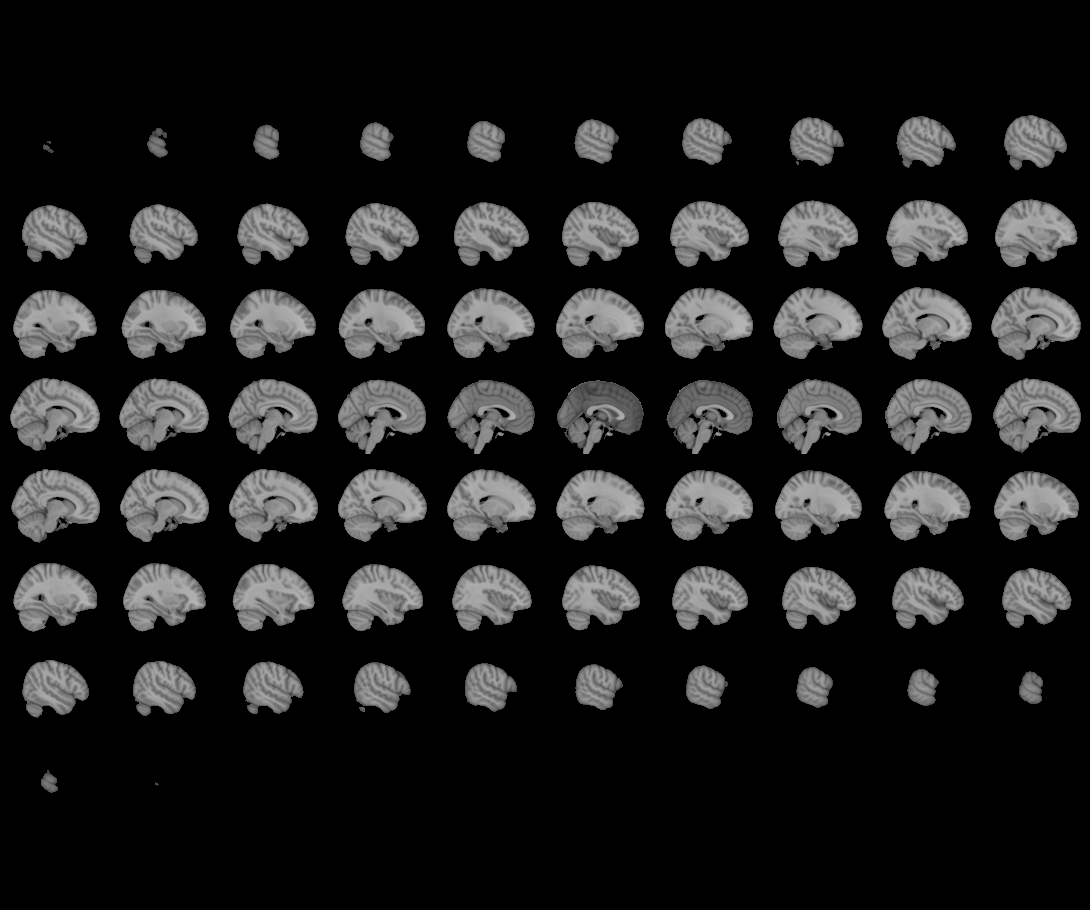
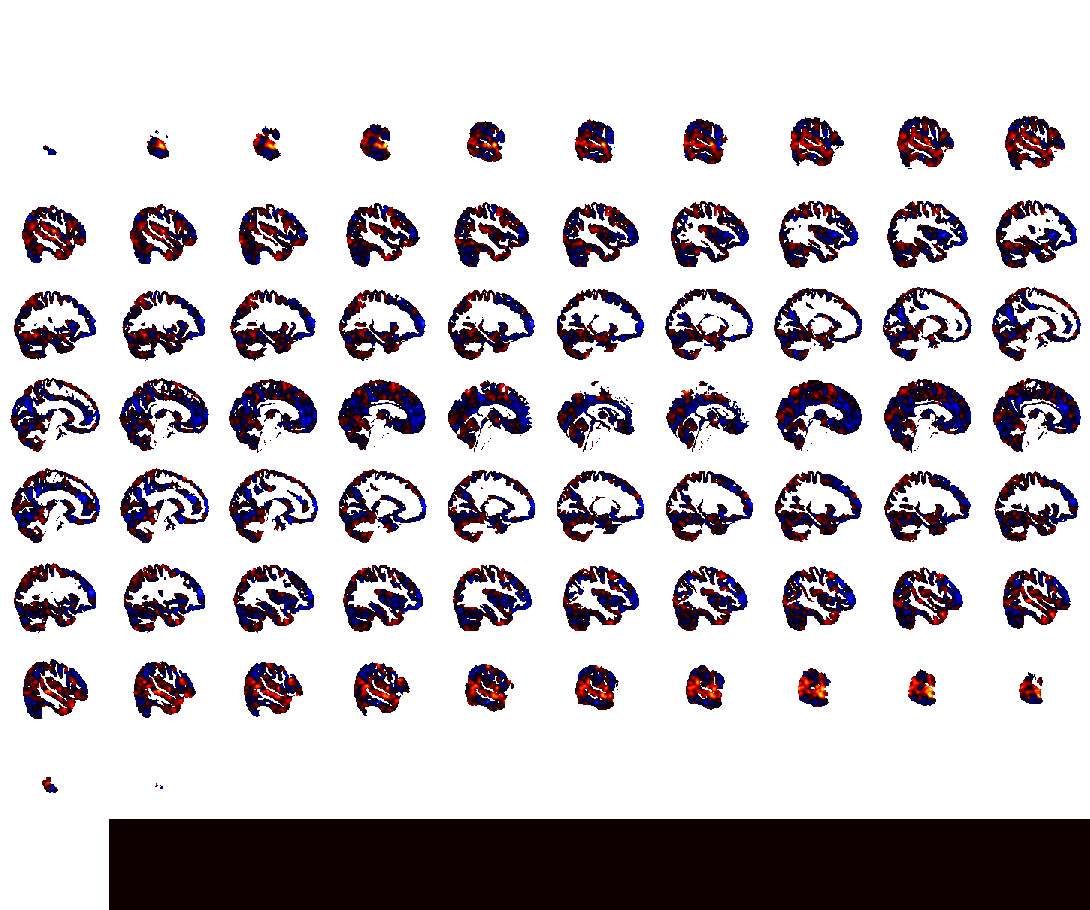

In [10]:
# Visualization of the nii image.
niifile = images[0]
condition = meta[0]['contrast_definition']

view = view_img(niifile,title=condition)
view

The whole fMRI scan is reduced to a signal spanning over 360 regions.



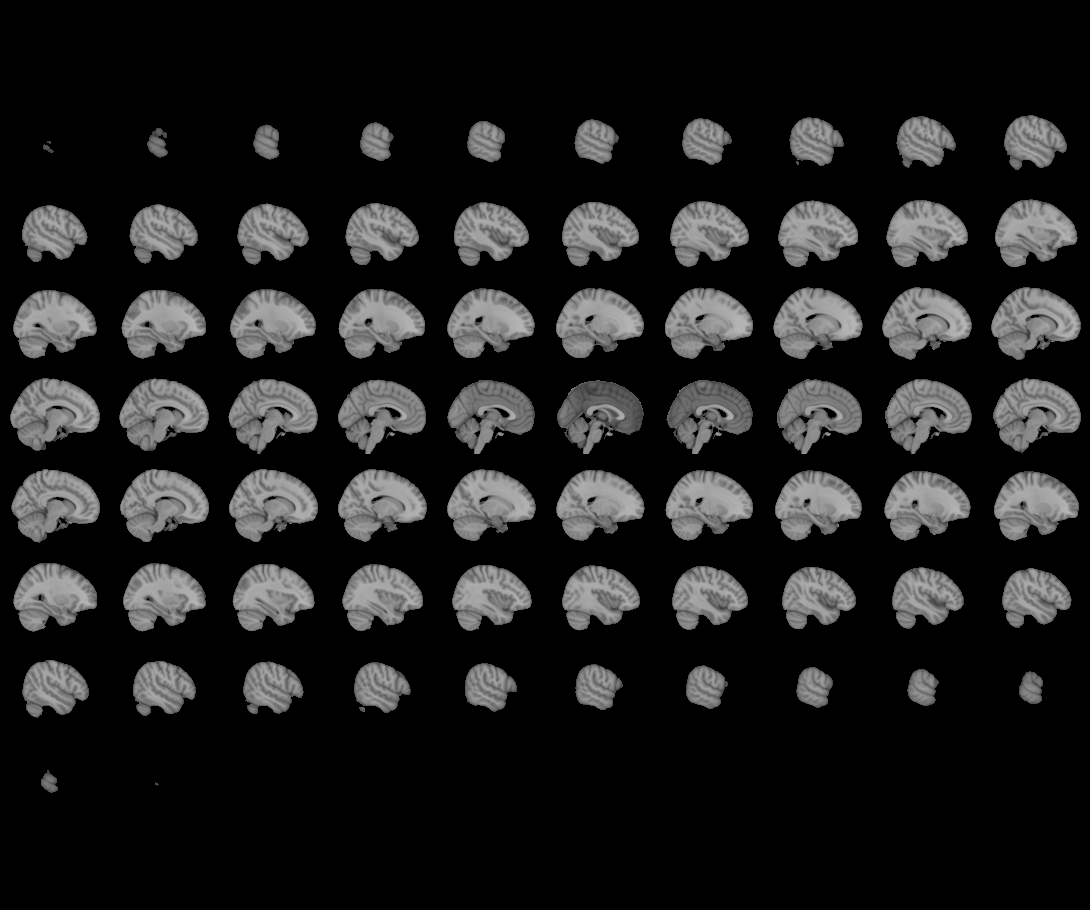
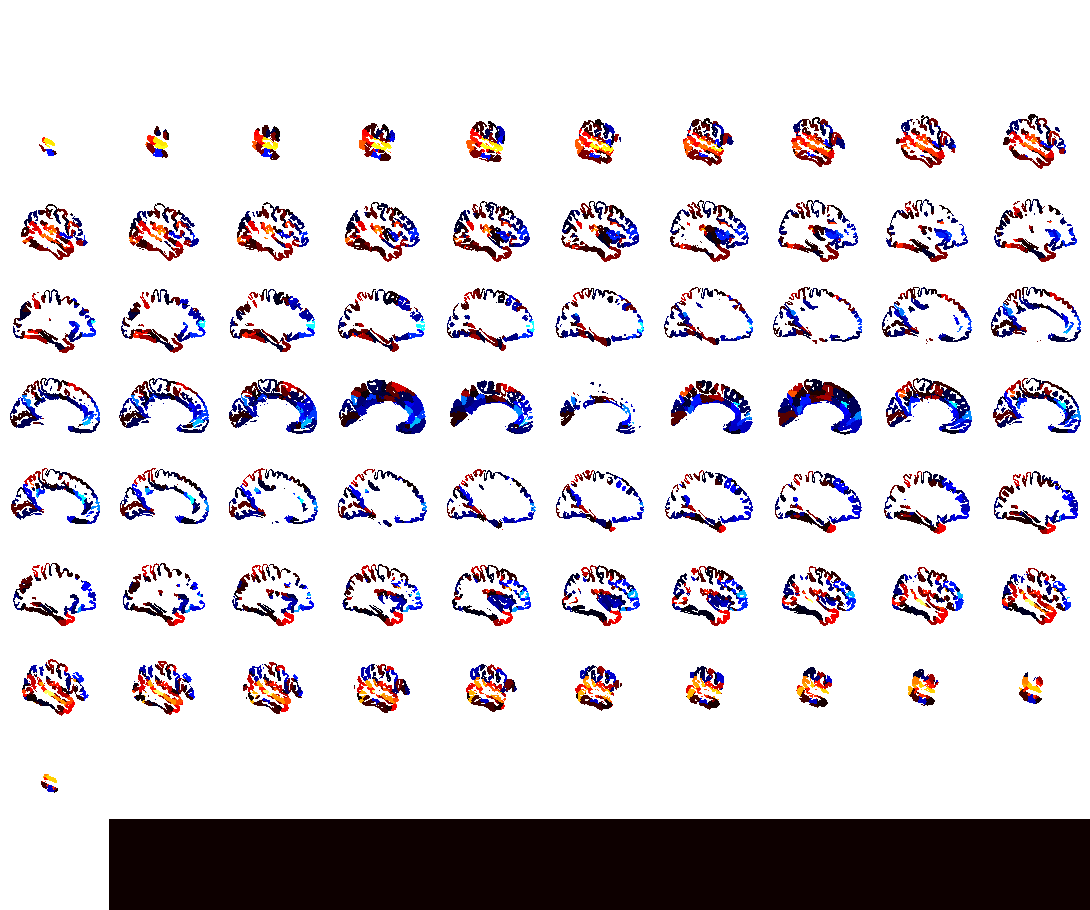

In [11]:
# Visualization of the parcellated image.
npzfile = os.path.splitext(os.path.splitext(niifile)[0])[0]+'.npz'
X = np.load(npzfile)['X']
print("The whole fMRI scan is reduced to a signal spanning over", X.shape[1], "regions.")
img = signals_to_img_labels(X,path_Glasser,mask_img=mask_mni)
view = view_img(img,title=condition)
view

/home/brain/anaconda3/envs/myriam/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/home/brain/anaconda3/envs/myriam/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':



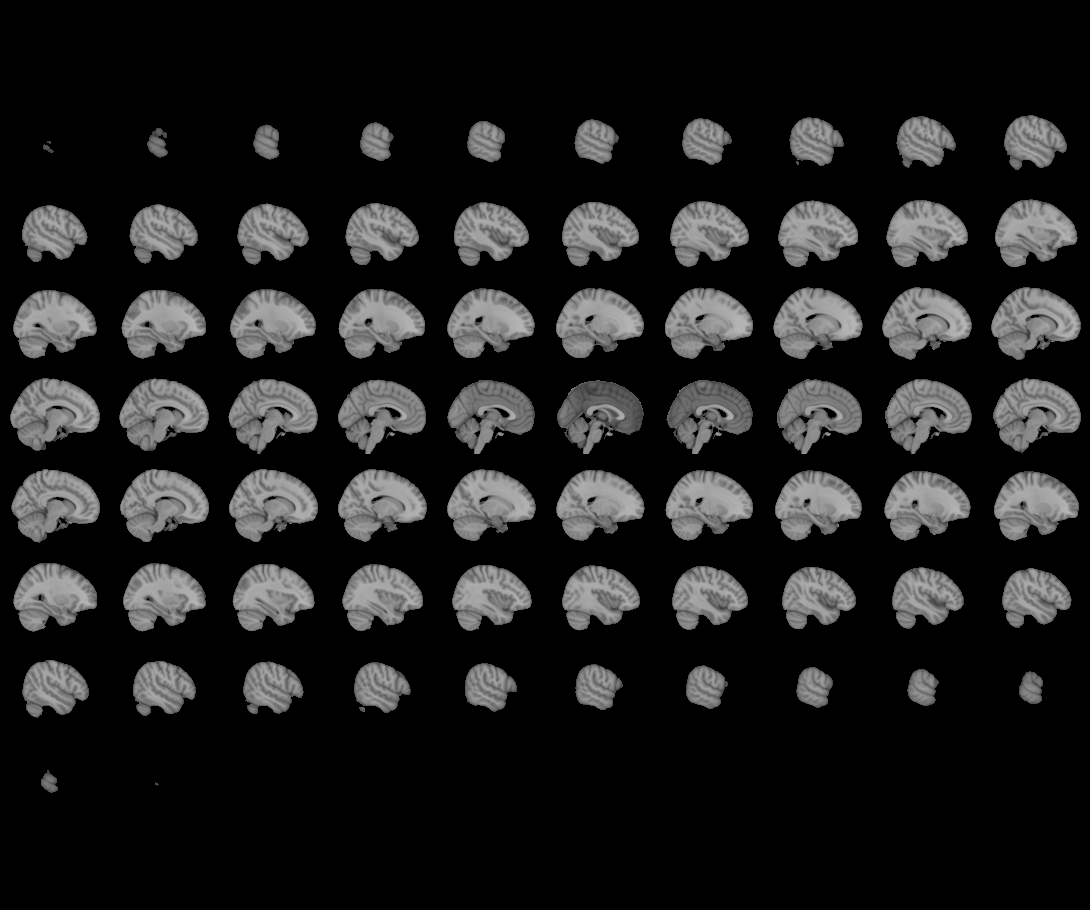
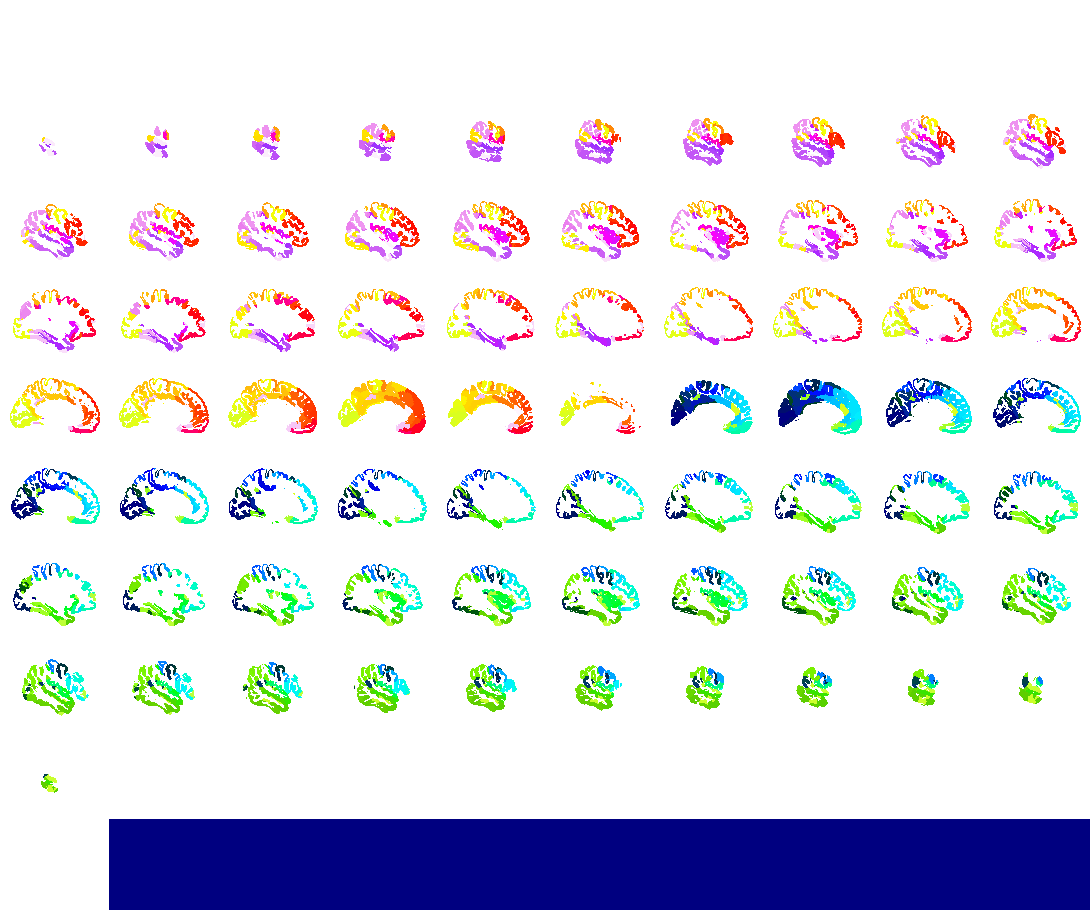

In [12]:
# Visualizing the ROI in a brain.

# Glasser contains 360 regions but their labels are floatting values between 0 and 54000.
# To better visualize the ROI, we can reindex the regions' labels. 

# First, we retrieve the data.
roi = load_img(path_Glasser)
data = roi.get_data()

# Then, we create a copy of the data in which, 
# we replace each label by its index in the sorted array of all labels.
indexes = np.unique(roi.get_data())

new_data = np.zeros(data.shape)
for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        for z in range(data.shape[2]):
            value = data[x, y, z]
            index = np.where(indexes==value)[0]
            new_data[x, y, z] = index

# Finally, we save the reindexed version of Glasser and we plot it.
reindexed_roi = nib.Nifti1Image(new_data, roi.affine, roi.header)
nib.save(reindexed_roi, 'reindexed_roi.nii')
atlas = view_img('reindexed_roi.nii', vmax=360, symmetric_cmap=False, threshold=0.001, cmap='gist_ncar')
atlas

## d. Splitting the dataset into three datasets: base / validation / novel.

To create a benchmark dataset for few-shot learning, we need to split the classes into three sets: base / validation / novel. 

The first two are used to extract general knowledge. The last one to mimic studies with few examples. In our github, we already provide the splits we used in our article.

If you want to generate a new split, you can follow our code and uncomment the last three lines.

In [13]:
# Split classes randomly.
# We only enforce that data samples computed from the same task are in the same set.
all_tasks = np.unique(tasks)
split = np.random.choice(all_tasks, replace=False, size=len(all_tasks))

In [14]:
train_tasks = split[:15]
val_tasks = split[15:20]
test_tasks = split[20:]

In [15]:
# In three csv files (corresponding to the three splits), we store the path of the images and their labels.
train_data = []
val_data = []
test_data = []
train_classes = []
val_classes = []
test_classes = []

for i, task in enumerate(tasks):
    filename = images[i].split('/')[-1].split('.')[0]
    label = labels[i]
    infos = meta[i]
    
    if task in train_tasks:
        train_data.append((filename, label, task, infos))
        if label not in train_classes:
            train_classes.append(label)
    elif task in val_tasks:
        val_data.append((filename, label, task, infos))
        if label not in val_classes:
            val_classes.append(label)
    elif task in test_tasks:
        test_data.append((filename, label, task, infos))
        if label not in test_classes:
            test_classes.append(label)
    else:
        if task != 'bang':
            raise NameError(task)

In [16]:
print('The base set contains ', len(train_classes), 'classes.')
print('The validation set contains ', len(val_classes), 'classes.')
print('The novel set contains ', len(test_classes), 'classes.')

The base set contains  53 classes.
The validation set contains  38 classes.
The novel set contains  15 classes.


In [17]:
print('The base set contains ', len(train_data), 'data samples.')
print('The validation set contains ', len(val_data), 'data samples.')
print('The novel set contains ', len(test_data), 'data samples.')

The base set contains  1706 data samples.
The validation set contains  1772 data samples.
The noval set contains  370 data samples.


In [21]:
# Save the splits in a folder.
def save_pd_to_csv(file, name):
    df = pd.DataFrame(file, columns = ['Filename', 'Label', 'Task', 'Meta'])
    if not os.path.exists('my_split'):
        os.makedirs('my_split')
    df.to_csv(path_or_buf=f'my_split/{name}.csv', index=False)

# save_pd_to_csv(train_data, 'train')
# save_pd_to_csv(val_data, 'val')
# save_pd_to_csv(test_data, 'test')